# Lecture 14: Outliers and Imputation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

sns.reset_orig()
sns.set(font_scale=1.5)
%matplotlib inline

---

# Gaussian Outliers

In [2]:
%reload_ext sql
%sql postgresql://localhost:5432/postgres

In [3]:
%sql SELECT setseed(0.42) -- to fix randomness

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

setseed
""


Just like a Python package, we need to import `tablefunc` in order to use the `normal_rand` function.

In [4]:
%sql CREATE EXTENSION IF NOT EXISTS tablefunc;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Assume our datapoints are truly Normal. Simulate them in `observations`.
* 1000 datapoints, $\mu = 50, \sigma = 5$.

In [5]:
%sql DROP TABLE IF EXISTS observations CASCADE;
%sql CREATE TABLE observations AS \
     SELECT normal_rand AS x \
     FROM normal_rand(1000, 50, 5);

results = %sql SELECT x FROM observations;

Running query in 'postgresql://localhost:5432/postgres'

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

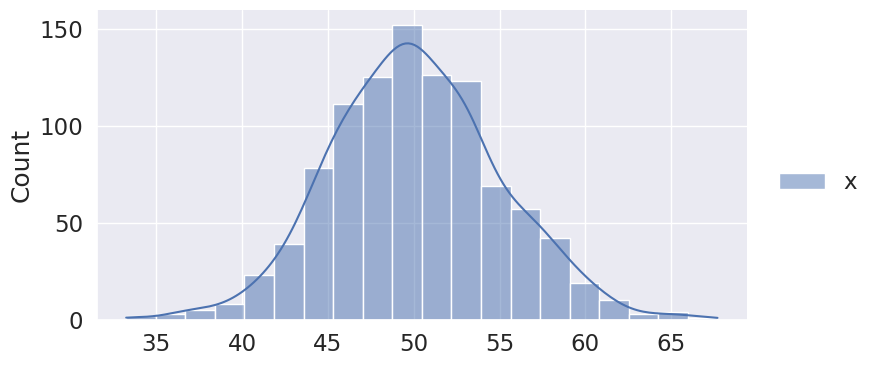

In [6]:
sns.displot(results.dict(), fill=True, kde=True, bins=20,
            height=4, aspect=2)

Construct a view called `normal_outliers` using the **2 sigma** metric.

In [7]:
# construct the view

In [8]:
%%sql
CREATE OR REPLACE VIEW normal_outliers AS
WITH bounds AS (
   SELECT avg(x) - 2*stddev(x) AS lo,
   avg(x) + 2*stddev(x) AS hi
   FROM observations
)
SELECT x AS outlier
FROM observations o, bounds b 
WHERE x NOT BETWEEN b.lo AND b.hi;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [9]:
# query the view
%sql SELECT * FROM normal_outliers;

Running query in 'postgresql://localhost:5432/postgres'

46 rows affected.

outlier
65.78271988422975
62.14480361066707
36.55122744379087
61.92285072093402
61.60697562844487
39.85192829966333
63.65918956243039
60.53154710413192
38.43179113189681
62.743476602815264


## What does this code do?

Running query in 'postgresql://localhost:5432/postgres'

1954 rows affected.

(30.0, 70.0)

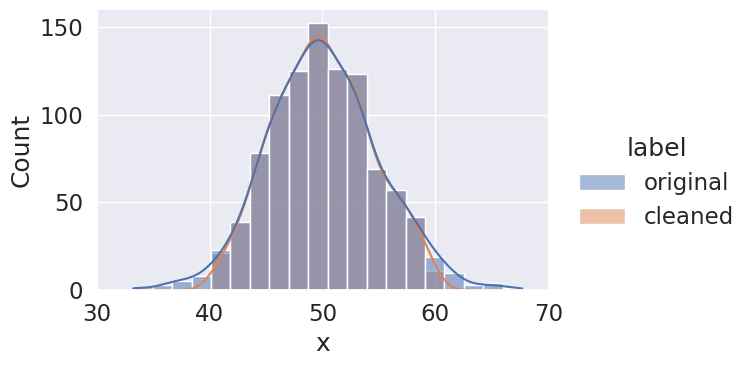

In [10]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
            height=4, aspect=1.5)
plt.xlim(30, 70)

<br/><br/><br/>
<br/><br/><br/>
<br/><br/><br/>

## Choices [hidden]

**A.**

Running query in 'postgresql://localhost:5432/postgres'

1046 rows affected.

(30.0, 70.0)

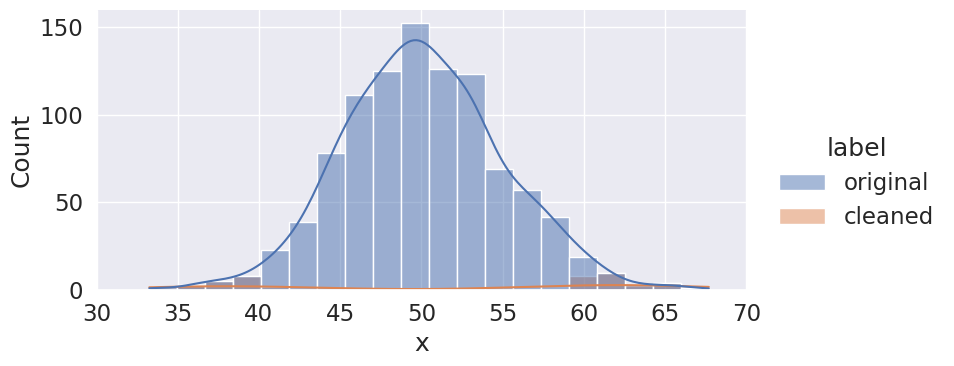

In [11]:
## plots outliers and original
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**B.**

Running query in 'postgresql://localhost:5432/postgres'

1954 rows affected.

(30.0, 70.0)

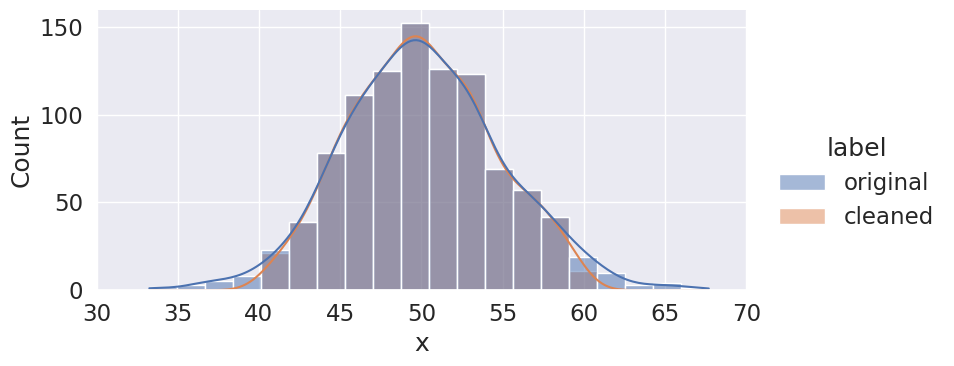

In [12]:
# correct
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**C.**

Running query in 'postgresql://localhost:5432/postgres'

1908 rows affected.

(30.0, 70.0)

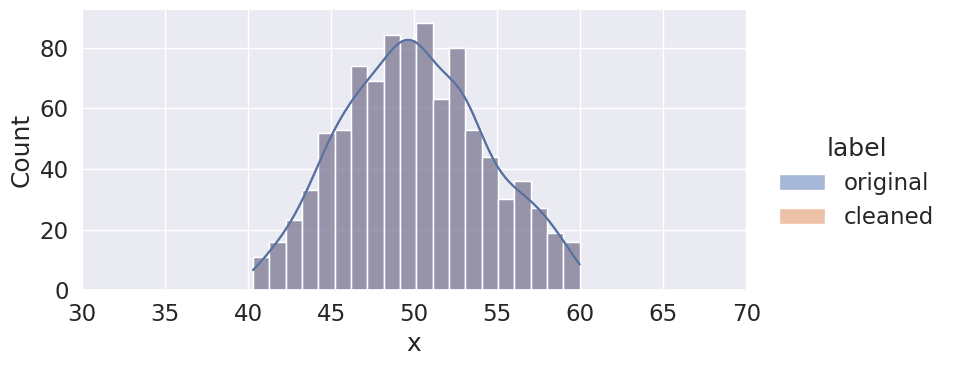

In [13]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers) \
               UNION ALL \
               SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**D.**

Running query in 'postgresql://localhost:5432/postgres'

954 rows affected.

(30.0, 70.0)

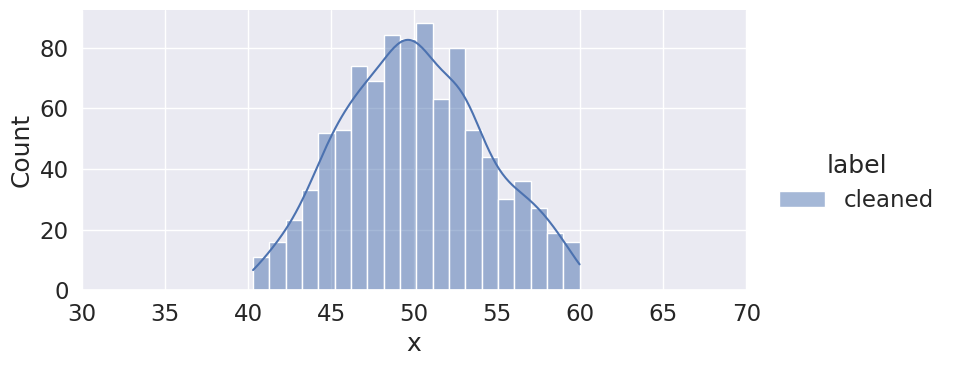

In [14]:
results = %sql SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

## What if we suddenly had extremes?

In [15]:
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

In [16]:
%sql SELECT min(x), max(x) FROM observations

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

min,max
33.24388909112553,676.935982446077


Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 700.0)

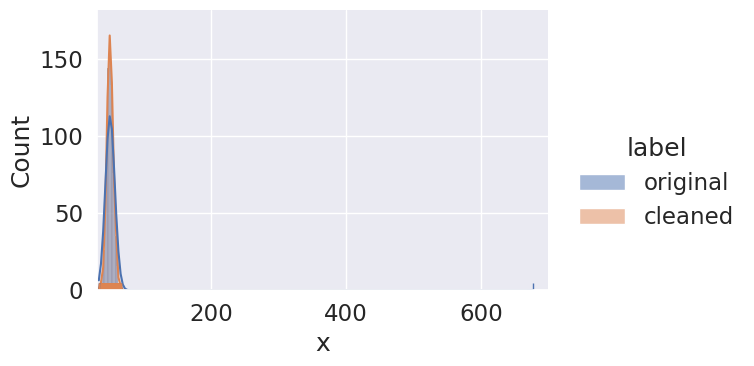

In [17]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 700)

Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 70.0)

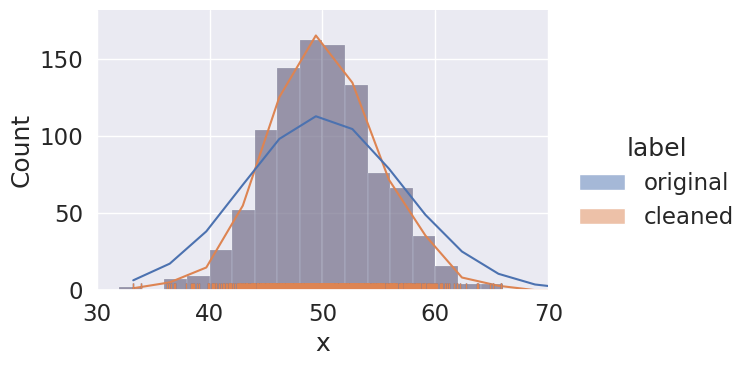

In [18]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

In [19]:
## reset before moving on
%sql UPDATE observations SET x = x/10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

# Winsorization

In [20]:
import numpy as np

In [21]:
arr = np.array([92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, -40, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr

array([  92,   19,  101,   58, 1053,   91,   26,   78,   10,   13,  -40,
        101,   86,   85,   15,   89,   89,   28,   -5,   41])

In [22]:
np.mean(arr), np.median(arr)

(101.5, 68.0)

In [23]:
np.percentile(arr, 95, method='nearest')

101

In [24]:
np.percentile(arr, 5, method='nearest')

-5

In [25]:
arr_winsorized = np.array([92, 19, 101, 58, 101, 91, 26, 78, 10, 13, -5, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr_winsorized

array([ 92,  19, 101,  58, 101,  91,  26,  78,  10,  13,  -5, 101,  86,
        85,  15,  89,  89,  28,  -5,  41])

In [26]:
np.mean(arr_winsorized), np.median(arr_winsorized)

(55.65, 68.0)

# Trimming vs. Winsorizatoin

In [27]:
%%sql
CREATE OR REPLACE VIEW p1p99 AS
SELECT percentile_cont(.01) WITHIN GROUP (ORDER BY x) AS p1,
           percentile_cont(.99) WITHIN GROUP (ORDER BY x) AS p99
      FROM observations;
SELECT * FROM p1p99;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

p1,p99
38.43109098130509,61.9232183423137


In [28]:
%%sql
CREATE OR REPLACE VIEW trimmed_observations AS
SELECT o.x, 'trimmed' AS label
  FROM observations o, p1p99 p
 WHERE o.x BETWEEN p.p1 AND p.p99
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

CREATE OR REPLACE VIEW trimmed_outliers AS
SELECT o.*
  FROM observations o, p1p99 p
 WHERE o.x NOT BETWEEN p.p1 AND p.p99;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

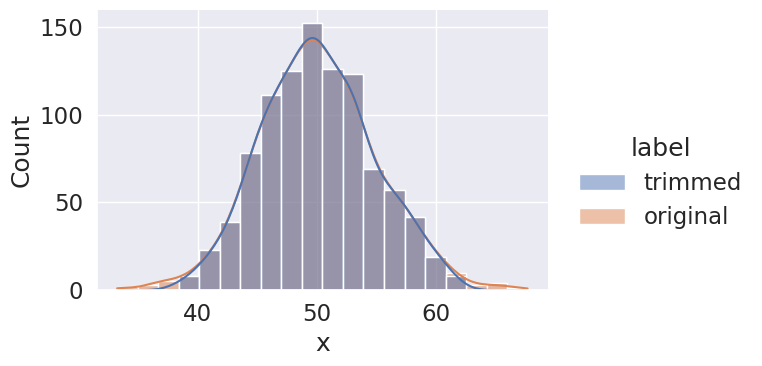

In [29]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20,
           height=4, aspect=1.5)

## Does corruption affect?

In [30]:
# corrupt one value
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

Turns out, we still have as many outliers, which we trim.

Because we are trimming based on the order of the data and not on the distribution statistics (mean/SD)

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

(30.0, 70.0)

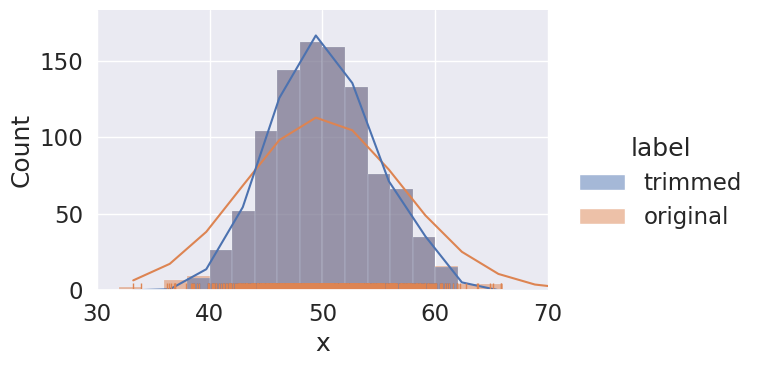

In [31]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

## Winsorization

In [32]:
## reset before moving on
# %sql UPDATE observations SET x = x*10 \
#       WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

In [33]:
%%sql
CREATE OR REPLACE VIEW winsorized_observations AS
SELECT CASE WHEN o.x BETWEEN p.p1 AND p.p99 THEN o.x
            WHEN o.x < p.p1 THEN p.p1
            WHEN o.x > p.p99 THEN p.p99
        END AS x,
      'winsorized' AS label
  FROM observations o, p1p99 p
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

2000 rows affected.

(30.0, 70.0)

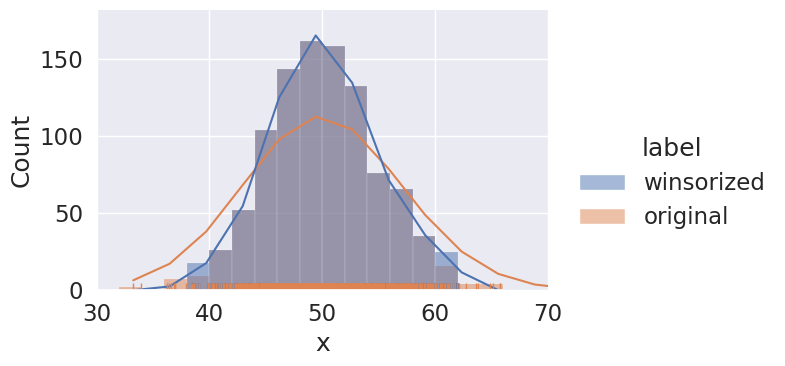

In [34]:
results = %sql SELECT * from winsorized_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

In [35]:
%%sql 
SELECT 'orig' AS distribution, min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM observations
UNION ALL
SELECT 'winsorized', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM winsorized_observations WHERE label = 'winsorized'
UNION ALL 
SELECT 'trimmed', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM trimmed_observations WHERE label = 'trimmed';

Running query in 'postgresql://localhost:5432/postgres'

3 rows affected.

distribution,min,p25,median,p75,max,avg,stddev,count
orig,33.24388909112553,46.76332260258399,49.90519697388744,53.084771695348394,676.935982446077,50.709949206144934,20.421033385050517,1000
winsorized,38.43109098130509,46.76332260258399,49.90519697388744,53.084771695348394,61.9232183423137,50.09749477430341,4.812893108231815,1000
trimmed,38.43179113189681,46.81855749035703,49.90519697388744,53.06435883287555,61.92285072093402,50.09586906231347,4.562722157959657,980


# Robustness, Mean, Median, Hampel X84

In [36]:
%%sql
-- percentile_disc returns an actual data value near the percentile
-- percentile_cont returns an interpolated value at the percentile
CREATE OR REPLACE VIEW median AS
(SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median
  FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [37]:
%%sql
CREATE OR REPLACE VIEW mad AS
WITH
absdevs AS
(SELECT abs(x - median) as d
   FROM observations, median)
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY d) as mad
  FROM absdevs;
    
SELECT median, mad
  FROM median, mad;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

median,mad
49.90519697388744,3.1616553325657577


In [38]:
%%sql
CREATE OR REPLACE VIEW hampelx84x2_observations AS
SELECT o.x,
      'hampelx84x2' AS label
  FROM observations o, median, mad
 WHERE o.x BETWEEN (median-2*1.4826*mad) AND (median+2*1.4826*mad)
UNION ALL
SELECT o.x, 'orig' AS label
  FROM observations o;

CREATE OR REPLACE VIEW Hampel84x2_outliers AS
SELECT x
  FROM observations o, median, mad
 WHERE x NOT BETWEEN (median - 2*1.4826*mad) AND (median + 2*1.4826*mad);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1941 rows affected.

(30.0, 70.0)

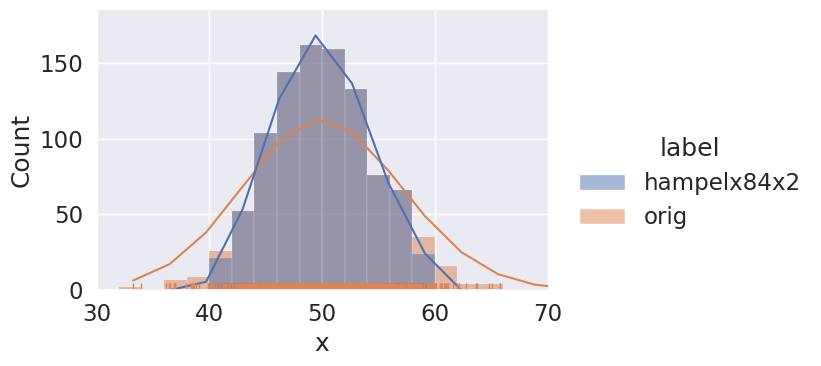

In [39]:
results = %sql SELECT * FROM hampelx84x2_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

# GNIS data

This is the GNIS dataset from the previous lecture. If you didn't load in the database, run the below cell before connecting.

In [40]:
!psql -h localhost -d gnis -c 'SELECT pg_terminate_backend(pg_stat_activity.pid) FROM pg_stat_activity WHERE datname = current_database() AND pid <> pg_backend_pid();'
!psql -h localhost -c 'DROP DATABASE IF EXISTS gnis'
!psql -h localhost -c 'CREATE DATABASE gnis' 
!psql -h localhost -d gnis -f ../lec13/data/gnis.sql

 pg_terminate_backend 
----------------------
(0 rows)

DROP DATABASE
CREATE DATABASE
SET
SET
SET
SET
SET
 set_config 
------------
 
(1 row)

SET
SET
SET
SET
SET
SET
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
COPY 3195
COPY 11533
CREATE INDEX


In [41]:
%reload_ext sql
%sql postgresql://localhost:5432/gnis

Connecting and switching to connection postgresql://localhost:5432/gnis

In [42]:
%sql SELECT setseed(0.12345);

Running query in 'postgresql://localhost:5432/gnis'

1 rows affected.

setseed
""


In [43]:
%%sql
DROP TABLE IF EXISTS holey CASCADE;
CREATE TABLE holey AS 
SELECT feature_id, feature_name, feature_class, state_alpha, county_name, 
       prim_lat_dec, prim_long_dec, 
       CASE WHEN random() > 0.9 THEN NULL
            ELSE elev_in_m
        END AS elev_in_m
  FROM national;
SELECT count(elev_in_m)::float / count(*) FROM holey;

Running query in 'postgresql://localhost:5432/gnis'

11533 rows affected.

1 rows affected.

?column?
0.8755744385675887


## Schema 1. Default Value Imputation with SQL

In [44]:
%%sql
WITH elevavg AS (SELECT avg(elev_in_m) FROM holey)
SELECT h.*, 
       CASE WHEN h.elev_in_m IS NOT NULL THEN h.elev_in_m
            ELSE e.avg
        END AS imputed_elev_in_m
  FROM holey h, elevavg e
LIMIT 10;

Running query in 'postgresql://localhost:5432/gnis'

10 rows affected.

feature_id,feature_name,feature_class,state_alpha,county_name,prim_lat_dec,prim_long_dec,elev_in_m,imputed_elev_in_m
1230,Belmont Mountains,Range,AZ,Maricopa,33.642258,-112.9010129,931.0,931.0
1839,Bootlegger Saddle,Gap,AZ,Cochise,31.8931474,-109.2831176,2707.0,2707.0
2336,Cabeza Prieta Game Range,Park,AZ,Yuma,32.250056,-113.45074,275.0,275.0
2750,Chandler Springs,Spring,AZ,Navajo,35.3766788,-110.4754096,1685.0,1685.0
3032,Cline Well,Well,AZ,Cochise,31.9000849,-110.3428525,None,483.962467815409
3039,Clover Tank,Reservoir,AZ,Gila,33.8509816,-110.2577249,1563.0,1563.0
3060,Coat Spring,Spring,AZ,Navajo,36.12678,-110.3330424,1926.0,1926.0
3143,Comar Spring,Spring,AZ,Navajo,35.5308428,-110.4162424,1732.0,1732.0
3333,Cottonwood Creek,Stream,AZ,Coconino,36.050817,-111.9865535,800.0,800.0
3342,Cottonwood Creek,Stream,AZ,Mohave,36.901931,-112.5632547,1389.0,1389.0


## Scheme 2. Correlation across columns

In [45]:
# Training is an aggregate function
# Here we'll train the model in SQL just for fun
result = %sql SELECT regr_slope(elev_in_m, prim_long_dec), \
               regr_intercept(elev_in_m, prim_long_dec) FROM holey
slope, intercept = result[0]
slope, intercept

Running query in 'postgresql://localhost:5432/gnis'

1 rows affected.

(-10.314179001097786, -477.9603219322606)

In [46]:
%%sql
SELECT *, 
       CASE WHEN elev_in_m IS NOT NULL THEN elev_in_m
            ELSE {{slope}}*prim_long_dec + {{intercept}}
        END AS imputed_elev_in_m
  FROM holey
LIMIT 10;

Running query in 'postgresql://localhost:5432/gnis'

10 rows affected.

feature_id,feature_name,feature_class,state_alpha,county_name,prim_lat_dec,prim_long_dec,elev_in_m,imputed_elev_in_m
1230,Belmont Mountains,Range,AZ,Maricopa,33.642258,-112.9010129,931.0,931.0
1839,Bootlegger Saddle,Gap,AZ,Cochise,31.8931474,-109.2831176,2707.0,2707.0
2336,Cabeza Prieta Game Range,Park,AZ,Yuma,32.250056,-113.45074,275.0,275.0
2750,Chandler Springs,Spring,AZ,Navajo,35.3766788,-110.4754096,1685.0,1685.0
3032,Cline Well,Well,AZ,Cochise,31.9000849,-110.3428525,None,660.1356102444698
3039,Clover Tank,Reservoir,AZ,Gila,33.8509816,-110.2577249,1563.0,1563.0
3060,Coat Spring,Spring,AZ,Navajo,36.12678,-110.3330424,1926.0,1926.0
3143,Comar Spring,Spring,AZ,Navajo,35.5308428,-110.4162424,1732.0,1732.0
3333,Cottonwood Creek,Stream,AZ,Coconino,36.050817,-111.9865535,800.0,800.0
3342,Cottonwood Creek,Stream,AZ,Mohave,36.901931,-112.5632547,1389.0,1389.0


## Scheme 3. General model-based interpolation

We won't show the demo; check slides for the general idea.

In [47]:

%config SqlMagic.displaylimit = 100

## Scheme 4. [simple] Correlation across ordered rows

In [48]:
%%sql
-- The following doesn't work in PostgreSQL!
WITH buggy AS (
SELECT *,
       CASE WHEN elev_in_m IS NOT NULL THEN elev_in_m
            ELSE lag(elev_in_m, 1)
                 OVER (ORDER BY feature_id)
        END AS imputed_elev_in_m
  FROM holey
)
SELECT * FROM buggy ORDER BY elev_in_m DESC LIMIT 100;

Running query in 'postgresql://localhost:5432/gnis'

100 rows affected.

feature_id,feature_name,feature_class,state_alpha,county_name,prim_lat_dec,prim_long_dec,elev_in_m,imputed_elev_in_m
214923,Lewes Junior High School,School,DE,Sussex,38.7687232,-75.1460168,None,89.0
209568,Ox Hill,Populated Place,CT,Fairfield,41.2284297,-73.2190027,None,31.0
204786,San Acacio,Populated Place,CO,Costilla,37.2139025,-105.5644584,None,1712.0
205451,Berkshire,Populated Place,CT,Fairfield,41.4087069,-73.2595601,None,1945.0
205915,Calebs Peak,Summit,CT,Litchfield,41.7559276,-73.4648456,None,116.0
194300,Bull Pasture Well,Well,CO,Las Animas,37.6594568,-104.3541397,None,1692.0
198468,Gurley Dam,Dam,CO,San Miguel,38.035547,-108.2459128,None,None
189182,Lienhart Mine,Mine,CO,Chaffee,38.9377726,-106.2547437,None,3173.0
197727,Pine Brook Hill,Populated Place,CO,Boulder,40.0499857,-105.3147137,None,2601.0
198347,King Reservoir Number 1,Reservoir,CO,Mesa,38.8657673,-108.6665656,None,1568.0


In [49]:
%%sql
-- Here's a UDA fix from
-- https://stackoverflow.com/questions/18987791/how-do-i-efficiently-select-the-previous-non-null-value
CREATE OR REPLACE FUNCTION coalesce_agg_sfunc(state anyelement, value anyelement) RETURNS anyelement AS
$$
    SELECT coalesce(value, state);
$$ LANGUAGE SQL;

CREATE AGGREGATE coalesce_agg(anyelement) (
    SFUNC = coalesce_agg_sfunc,
    STYPE  = anyelement);

Running query in 'postgresql://localhost:5432/gnis'

++
||
++
++

In [50]:
%%sql
-- Fixed to handle repeated NULLs
WITH fixed AS (
SELECT *,
       coalesce_agg(elev_in_m) OVER (order by feature_id) AS imputed_elev_in_m
  FROM holey
)
SELECT * FROM fixed ORDER BY imputed_elev_in_m DESC LIMIT 100;

Running query in 'postgresql://localhost:5432/gnis'

100 rows affected.

feature_id,feature_name,feature_class,state_alpha,county_name,prim_lat_dec,prim_long_dec,elev_in_m,imputed_elev_in_m
1416580,Browne Tower,Summit,AK,Denali,63.1000583,-150.9314441,4628.0,4628.0
188010,Grizzly Peak,Summit,CO,La Plata,37.6076296,-107.5818648,4171.0,4171.0
191939,Spread Eagle Peak,Summit,CO,Custer,38.1252369,-105.6435197,4090.0,4090.0
187393,Emery Peak,Summit,CO,San Juan,37.8882556,-107.6210535,4054.0,4054.0
181832,Baker Mountain,Summit,CO,Clear Creek,39.6607654,-105.8402538,3832.0,3832.0
1703800,Lucky Jim One Mine,Mine,CO,Park,39.1519347,-105.742509,None,3728.0
1703775,Park County Claims Mine,Mine,CO,Park,39.3510997,-105.9869614,3728.0,3728.0
393894,Donaldson Peak,Summit,ID,Custer,44.0639981,-113.7003853,3661.0,3661.0
1599419,Dundee Mountain,Summit,WY,Park,43.8771622,-109.2682693,3640.0,3640.0
939450,Master Man Mine,Mine,NM,Colfax,36.6297542,-105.2088936,3633.0,3633.0
